In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from scipy import interpolate

In [52]:
# Set plt settings for a better looking plot
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 10
plt.rcParams["lines.markeredgewidth"] = 2
plt.rcParams["lines.markerfacecolor"] = "none"
plt.rcParams["lines.markeredgecolor"] = "black"

In [53]:
def get_data(entity, project, jobs=None):
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)
    if jobs is not None:
        runs = [r for r in runs if "job" in r.config and int(r.config["job"]) in jobs]

    data = {}
    for r in runs:
        g = r.config["problem"]
        a = r.config["algo"]
        if g not in data:
            data[g] = {}
        if a not in data[g]:
            data[g][a] = []
        data[g][a].append(r)
    return data

In [93]:
class GroupedRun:
    def __init__(self, algo, runs):
        self.algo = algo
        self.runs = runs
        self.interpolators = {}
        self.ranges = {}

    def interpolate(self, y):
        if y not in self.interpolators:
            self.interpolators[y] = []
            self.ranges[y] = (- np.inf, np.inf)
        for r in self.runs:
            h = r.history()
            i = interpolate.interp1d(h["evaluations"], h[y])
            self.interpolators[y].append(i)
            self.ranges[y] = (max(self.ranges[y][0], h["evaluations"].min()), min(self.ranges[y][1], h["evaluations"].max()))

    def compute(self, field, x):
        # filter x for range
        x = [x[i] for i in range(len(x)) if self.ranges[field][0] <= x[i] <= self.ranges[field][1]]
        y = []
        for i in self.interpolators[field]:
            y.append(i(x))
        return np.array(x), np.array(y)

    def get_mean_std(self, field, x):
        x, y = self.compute(field, x)
        return np.mean(y, axis=0), np.std(y, axis=0)

In [54]:
entity = "sureli"
project = "ucea"
# jobs = None
jobs = [766713, 766237, 766726, 766718, 766710, 766716, 76627]

In [55]:
games = get_data(entity, project, jobs)

In [56]:
for g, a in games.items():
    print(f"{g} - {list(a.keys())}")

chaser - ['UCEA']
leaper - ['UCEA']
starpilot - ['UCEA']
leading_ones - ['UCEA', 'MultiEA', 'EA']


In [57]:
runs = games["leading_ones"]

In [39]:
def plot_graphs(runs):
    pass

In [63]:
r = runs["UCEA"]

In [94]:
g = GroupedRun("UCEA", runs["UCEA"])

KeyError: 'time'

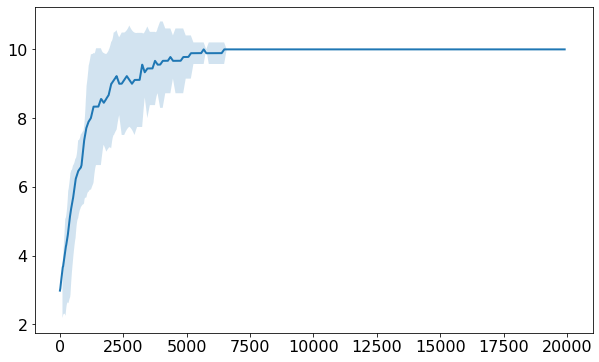

In [95]:
for a, r in runs.items():
    g = GroupedRun(a, r)
    for y in ["fitness", "time"]:
        g.interpolate(y)
        mean, std = g.get_mean_std(y, np.arange(g.ranges[y][0], g.ranges[y][1]))
        plt.plot(mean, label=a)
        plt.fill_between(np.arange(g.ranges[y][0], g.ranges[y][1]), mean - std, mean + std, alpha=0.2)
    plt.legend()
    plt.title(f"{a}")
    plt.show()

In [84]:
g.interpolate("fitness")

In [88]:
x, y_all = g.compute("fitness", range(10000))

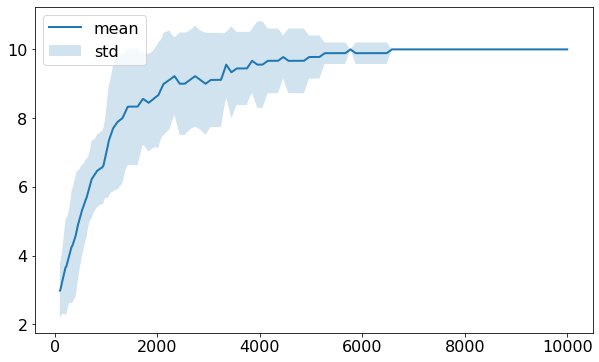

In [89]:
mean = np.mean(y_all, axis=0)
std = np.std(y_all, axis=0)
# Plot the mean and the standard deviation
plt.plot(x, mean, label="mean")
plt.fill_between(x, mean - std, mean + std, alpha=0.2, label="std")
plt.legend()
plt.show()

In [80]:
g.ranges

{'fitness': (100, 20008)}